# DAA Experiment Harness (Template)
**Tujuan**: kerangka eksperimen untuk membandingkan *Algoritma Depth First Search* vs *Algoritma Breadth First Search* pada instance unik per kelompok.
1. Isi `DFS` dan `BFS`.
2. Sesuaikan `generate_instances` atau loader data.
3. Atur `Ns`, `repeats`, `seed`.


## Pembuatan Graph

In [25]:
import os, time, random, statistics
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import json
import os

# Buat folder data jika belum ada
os.makedirs("data", exist_ok=True)

In [26]:
def generate_bem_graph(n_total, seed):
    random.seed(seed)
    n_a = int(n_total * 0.4)
    n_b = int(n_total * 0.35)
    n_c = n_total - n_a - n_b
    G_A = nx.barabasi_albert_graph(n=n_a, m=10, seed=seed)
    G_B = nx.barabasi_albert_graph(n=n_b, m=10, seed=seed+1)
    G_C = nx.barabasi_albert_graph(n=n_c, m=10, seed=seed+2)
    G_total = nx.disjoint_union_all([G_A, G_B, G_C])
    G_total.add_edge(0, n_a)             
    G_total.add_edge(n_a, n_a + n_b)
    G_total.add_edge(0, n_a + n_b)     
    node_data = {}
    nama = []
    file = open("data/nama.csv","a+")
    file.seek(0)
    for i in file.readlines() :
        nama.append(i)
    file.close()
    nnama = len(nama) - 1
    for node_id in G_total.nodes():
        if node_id < n_a:
            divisi = "Divisi Acara"
            jabatan = "Ketua Divisi" if node_id == 0 else "Staff"
        elif node_id < (n_a + n_b):
            divisi = "Divisi Humas"
            jabatan = "Ketua Divisi" if node_id == n_a else "Staff"
        else:
            divisi = "Divisi Logistik"
            jabatan = "Ketua Divisi" if node_id == (n_a + n_b) else "Staff"
        nama1 = nama.pop(random.randint(0,nnama)).strip()
        nnama -= 1
        node_data[str(node_id)] = {
            "nama": nama1,
            "divisi": divisi,
            "jabatan": jabatan,
            "ipk": round(random.uniform(2.5, 4.0), 2)
        }
    adj_list = nx.to_dict_of_lists(G_total)
    file = open(f"data/Biodata N{n_total} seed({seed}).csv","w")
    file.write("id;nama;divisi;jabatan;ipk\n")
    for i in range(n_total) :
        file.write(f"{i};{node_data[str(i)]['nama']};{node_data[str(i)]['divisi']};{node_data[str(i)]['jabatan']};{node_data[str(i)]['ipk']}\n")
    
    return adj_list, node_data

## Implementasi Algoritma DFS (Depth First Search)

### DFS Searching

In [27]:
def dfs(adj_list,start,goal,hasil) :
    for i in adj_list[start] :
        if i not in hasil and i != start :
            hasil[i] = [start]
            if i == goal :
                return True
            if dfs(adj_list,i,goal,hasil) :
                return True
    return False

### DFS Transversal

In [28]:
def dfs_trans(adj_list,start,hasil,sepuh) :
    for i in adj_list[start] :
        if i not in hasil and i != sepuh :
            hasil[i] = [start]
            dfs_trans(adj_list,i,hasil,sepuh)
    return hasil

## Implementasi Algoritma BFS (Breadth First Search)

### BFS Searching

In [29]:
def bfs(adj_list,start,goal,hasil) :
    qiu = []
    for i in adj_list[start] :
        if i not in hasil :
            hasil[i] = [start]
            qiu.append(i)
            if i == goal :
                return True
    while qiu :
        cabang = qiu.pop(0)
        for i in adj_list[cabang] :
            if i not in hasil :
                hasil[i] = [cabang]
                qiu.append(i)
            if i == goal :
                return True
    return False

### BFS Transversal

In [30]:
def bfs_trans(adj_list,start,hasil,useless) :
    hasil[start] = []
    qiu = []
    for i in adj_list[start] :
        if i not in hasil and i != start :
            hasil[i] = [start]
            qiu.append(i)
    while qiu :
        cabang = qiu.pop(0)
        for i in adj_list[cabang] :
            if i not in hasil and i != start :
                hasil[i] = [cabang]
                qiu.append(i)
    return hasil

## Evaluator & Timing

In [31]:
def evaluate_solution(sol):
    # Untuk sorting: gap=0 jika terurut.
    return 0.0 if isinstance(sol, list) and all(sol[i]<=sol[i+1] for i in range(len(sol)-1)) else 1.0

def run_once(algorithm, adj_list,start,hasil,sepuh):
    t0=time.perf_counter(); out=algorithm(adj_list,start,hasil,sepuh); dt=(time.perf_counter()-t0)*1000.0
    return dt, evaluate_solution(out)

## Eksekusi Eksperimen (atur parameter)

In [32]:
Ns=[100,400,700,1000]
repeats=5
base_seed= 121437 
start = 5
rows=[]

for n in Ns:
    for r in range(repeats):
        adj_list, node_data = generate_bem_graph(n, base_seed + r)      
        output_content = {
            "project": "connected_components_social_graph",
            "description": f"Graf BEM {n} nodes dengan Data Atribut",
            "n_nodes": n,
            "graph_adj": adj_list,
            "node_data": node_data
        }       
        filename = f"data/social_graph_N{n} seed({base_seed}).json"
        with open(filename, "w") as f:
            json.dump(output_content, f, indent=2)           
        dA, gA = run_once(dfs_trans, adj_list,start,{},start)
        dB, gB = run_once(bfs_trans, adj_list,start,{},start)
        rows.append({'n':n,'repeat':r,'algo':'DFS','time_ms':dA,'gap':gA})
        rows.append({'n':n,'repeat':r,'algo':'BFS','time_ms':dB,'gap':gB})

df=pd.DataFrame(rows)
os.makedirs("results", exist_ok=True)
file = open("results/experiment_raw.csv","a+")
file.close()
df.to_csv('results/experiment_raw.csv', index=False)
summary=df.groupby(['algo','n']).agg(time_ms_mean=('time_ms','mean'), time_ms_sd=('time_ms','std'), gap_mean=('gap','mean')).reset_index()
summary.to_csv('results/summary.csv', index=False)

display(summary)

,algo,n,time_ms_mean,time_ms_sd,gap_mean
0,BFS,100,0.09920,0.050697,1.0
1,BFS,400,0.45694,0.144993,1.0
2,BFS,700,1.03852,0.438988,1.0
3,BFS,1000,1.58650,0.673248,1.0
4,DFS,100,0.16628,0.043134,1.0
5,DFS,400,0.60798,0.318100,1.0
6,DFS,700,1.45500,0.269630,1.0
7,DFS,1000,2.35360,0.835282,1.0


## Plot & Tabel

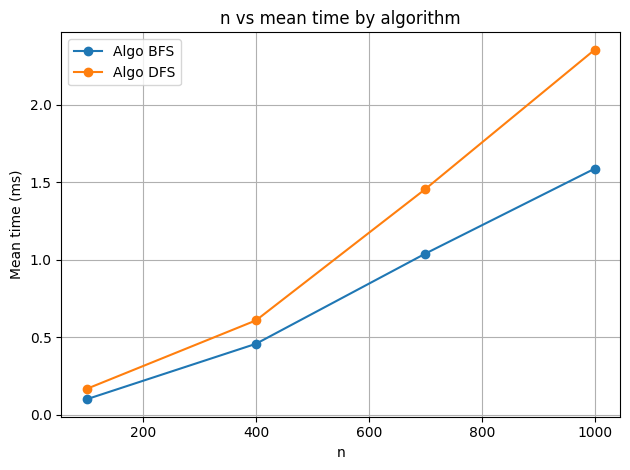

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6392\2968621134.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df['n'].unique()))


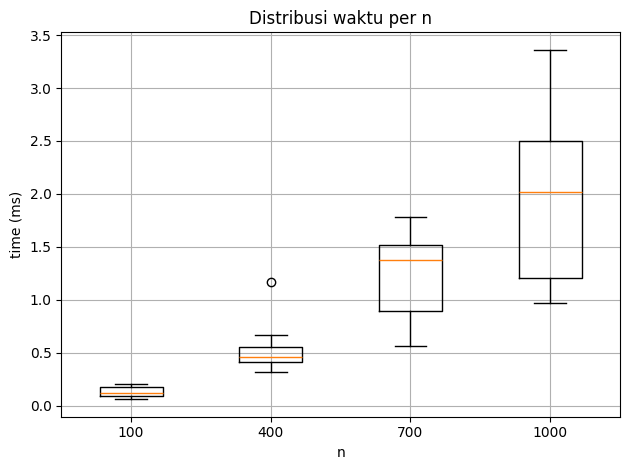

In [33]:
plt.figure()

for algo in sorted(df['algo'].unique()):
    xs=sorted(df['n'].unique())
    ys=[summary[(summary['algo']==algo)&(summary['n']==x)]['time_ms_mean'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo}')

plt.xlabel('n')
plt.ylabel('Mean time (ms)')
plt.title('n vs mean time by algorithm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_time.png', dpi=150)
plt.show()
plt.figure()

data=[df[df['n']==x]['time_ms'] for x in sorted(df['n'].unique())]
plt.boxplot(data, labels=sorted(df['n'].unique()))
plt.xlabel('n')
plt.ylabel('time (ms)')
plt.title('Distribusi waktu per n')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_box_time_per_n.png', dpi=150)
plt.show()

## (Opsional) Uji Statistik (paired t-test)

In [ ]:
try:
    from scipy.stats import ttest_rel

    for n in sorted(df['n'].unique()):
        a=df[(df['n']==n)&(df['algo']=='A')]['time_ms'].values
        b=df[(df['n']==n)&(df['algo']=='B')]['time_ms'].values
        t,p=ttest_rel(a,b)
        print(f'n={n}: t={t:.3f}, p={p:.4f}')

except Exception as e:
    print('SciPy tidak tersedia; lewati uji t berpasangan.', e)

n=500: t=14.704, p=0.0001
n=1000: t=40.786, p=0.0000
n=2000: t=101.120, p=0.0000
n=5000: t=55.545, p=0.0000


## Ekspor tabel LaTeX (opsional)

In [ ]:
latex_table=summary.rename(columns={'time_ms_mean':'Mean (ms)','time_ms_sd':'SD (ms)','gap_mean':'Gap'}).to_latex(index=False)

with open('results/summary.tex','w',encoding='utf-8') as f:
    f.write(latex_table)

print('Saved results/summary.tex')

Saved results/summary.tex
